### Importación Bibliotecas

In [1]:
!pip install imutils --quiet
!pip install livelossplot --quiet
from imutils import paths
from livelossplot.inputs.keras import PlotLossesCallback

Using TensorFlow backend.


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import keras
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from pathlib import Path
from sklearn.metrics import accuracy_score

from functions import get_size, train_valid_generator, plot_heatmap, add_value_labels
print(f'{sys.version}')
print(f'keras {keras.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'numpy {np.__version__}')

3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
keras 2.3.0
tensorflow 2.1.3
numpy 1.18.5


In [3]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


### Importación Imágenes para Entrenamiento

In [4]:
# Copiar las imágenes destinadas a los entrenamientosa a la instancia de Jupyter desde s3 de AWS. Hace falta hacerlo solamente la primera vez
#. !aws s3 sync s3://focusondrivinghenry/img './img' --quiet

In [5]:
# calcular el espacio utilizado en la máquina
print(get_size()/1000, 'bytes')

11851844.964 bytes


### Exploratory Data Analysis (Train Data)

In [6]:
train_data = f'./img/train'
test_data = f'./img/test_1000'
class_subset = sorted(os.listdir(train_data))
ac_labels = {"c0": "safe driving",
             "c1": "texting - right",
             "c2": "talking on the phone - right",
             "c3": "texting - left",
             "c4": "talking on the phone - left",
             "c5": "operating the radio",
             "c6": "drinking",
             "c7": "reaching behind",
             "c8": "hair and makeup",
             "c9": "talking to passenger"}

In [7]:
print(f'train_data {train_data}')
print(f'test_data {test_data}')
print(f'class_subset {class_subset}')

train_data ./img/train
test_data ./img/test_1000
class_subset ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


### Comprobación de que las imágenes destinadas a los entrenamientos tienen las mismas dimensiones

In [8]:
df = pd.DataFrame()
df_all_elements = pd.DataFrame()
directories = os.listdir(train_data)
for directory in directories:
    _dir = f'{train_data}/{directory}'
    print(f'directory {_dir}')
    len_files = len(os.listdir(_dir))
    img_list = paths.list_images(_dir)
    shape = []
    for i, img_path in enumerate(img_list):
        shape.append(cv2.imread(img_path).shape)
        if i > 5:
            break

    _directory = [directory] * len(shape)
    _label = [ac_labels[directory]] * len(shape)
    df_all_elements = df_all_elements.append(pd.DataFrame({'class': _directory,
                                                          'shape': shape,
                                                          'label': _label}),
                                            ignore_index=True)

    result = False
    listOfStrings = df_all_elements['shape']
    if len(listOfStrings) > 0:
        result = all(elem == listOfStrings[0] for elem in listOfStrings)
    if result:
        print("All Elements in List are Equal")
    else:
        print("All Elements in List are Not Equal")

    df = df.append(pd.DataFrame({'class': [directory],
                                'len': [len_files],
                                'shape': [listOfStrings[0]],
                                'label': [ac_labels[directory]]}),
                  ignore_index=True)

directory ./img/train/c7
All Elements in List are Equal
directory ./img/train/c2
All Elements in List are Equal
directory ./img/train/c1
All Elements in List are Equal
directory ./img/train/c9
All Elements in List are Equal
directory ./img/train/c4
All Elements in List are Equal
directory ./img/train/c3
All Elements in List are Equal
directory ./img/train/c8
All Elements in List are Equal
directory ./img/train/c5
All Elements in List are Equal
directory ./img/train/c6
All Elements in List are Equal
directory ./img/train/c0
All Elements in List are Equal


### Distribución del número de imágenes por categorías

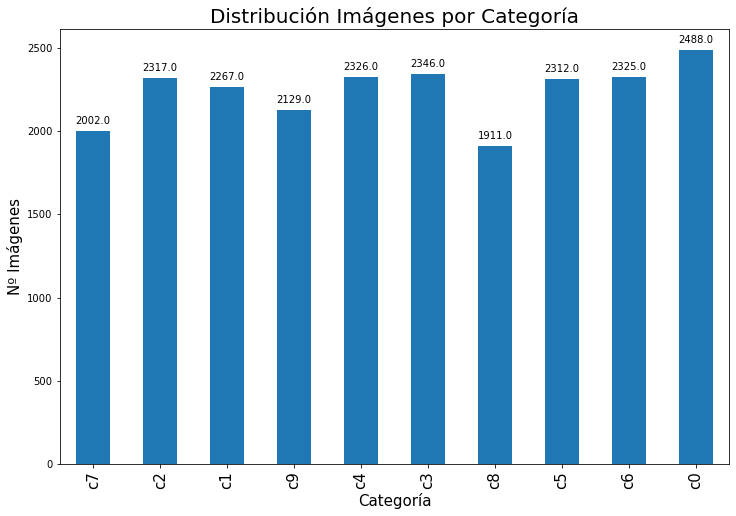

In [9]:
frequencies = list(df['len'].values)

freq_series = pd.Series(frequencies)

x_labels = list(df['class'].values)

plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Distribución Imágenes por Categoría', size=20)
ax.set_xlabel('Categoría', size=15)
ax.set_ylabel('Nº Imágenes', size=15)
ax.set_xticklabels(x_labels, size=15)

# Call the function above. All the magic happens there.
add_value_labels(ax)

plt.savefig("image.png")

### Preparación Conjunto de Imágenes para Entrenamiento y Test

In [10]:
n_model = int(input('generate model (1, 2, 3, 4, 5): '))
BATCH_SIZE = 32
train_generator, traingen, validgen = train_valid_generator(n_model, train_data, class_subset, BATCH_SIZE)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 
testgen = test_generator.flow_from_directory(test_data,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

generate model (1, 2, 3, 4, 5): 3
Found 19065 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.
Found 1002 images belonging to 10 classes.


### Pruebas "Data Augmentation"

In [11]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
img = load_img('./img/train/c0/img_100026.jpg')
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)
i = 0
for batch in train_generator.flow(x, batch_size=1,
                                 save_to_dir='./img/zoom',
                                 save_prefix='zoom4',
                                 save_format='jpeg'):
    i += 1
    if i > 10:
        break

 ### Definición del Modelo

In [12]:
input_shape = (224, 224, 3)
n_classes=len(class_subset)
optim = Adam(lr=0.0001)
fine_tune=2
n_epochs = 25

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [13]:
plot_loss_1 = PlotLossesCallback()
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                        patience=10,
                        restore_best_weights=True,
                        mode='min')

In [14]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0, n_model=1):
    print(f'**train model {n_model}')
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    if n_model == 4:
        conv_base = VGG19(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    else:
        conv_base = VGG16(include_top=False,
                         weights='imagenet', 
                         input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    if n_model == 1 or n_model == 2:
        top_model = Flatten(name="flatten")(top_model)
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(1072, activation='relu')(top_model)


    elif n_model == 3 or n_model == 4:
        top_model = Flatten(name="flatten")(top_model)
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(256, activation='relu')(top_model)
        top_model = Dense(64, activation='relu')(top_model)

    elif n_model == 5:
        top_model = Flatten(name="flatten")(top_model)
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(512, activation='relu')(top_model)
        top_model = Dense(256, activation='relu')(top_model)
        top_model = Dense(128, activation='relu')(top_model)
        top_model = Dense(64, activation='relu')(top_model)
        top_model = Dense(32, activation='relu')(top_model)
        
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


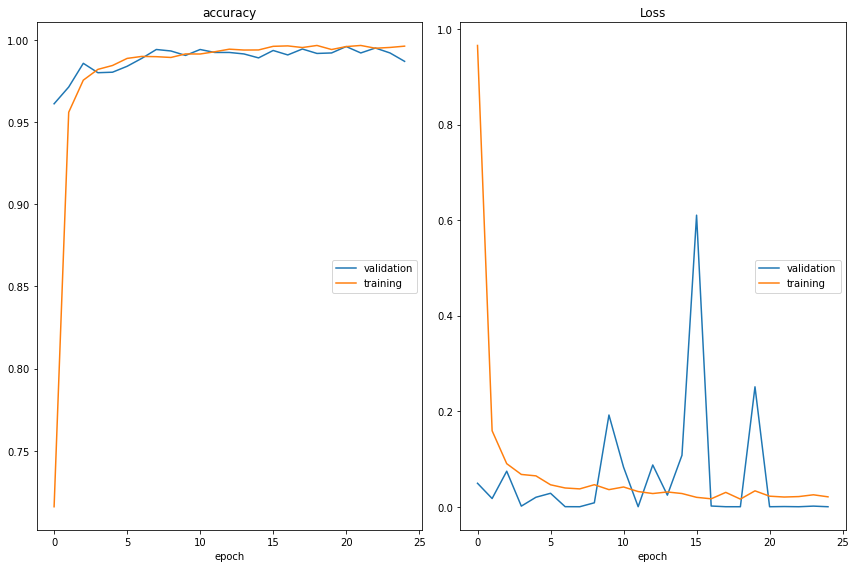

accuracy
	validation       	 (min:    0.961, max:    0.996, cur:    0.987)
	training         	 (min:    0.716, max:    0.997, cur:    0.996)
Loss
	validation       	 (min:    0.000, max:    0.610, cur:    0.000)
	training         	 (min:    0.016, max:    0.966, cur:    0.021)


In [15]:
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=f'./model/model{n_model}.hdf5',
                                save_best_only=True,
                                verbose=1)


# Ajuste del Modelo con fine-tuning
print(f'train model {n_model}')
model = create_model(input_shape, n_classes, optim, fine_tune, n_model)
model = model.fit(traingen,
                  epochs=n_epochs,
                  validation_data=validgen,
                  steps_per_epoch=n_steps, 
                  validation_steps=n_val_steps,
                  # callbacks=[tl_checkpoint_1, early_stop, PlotLossesCallback()],
                  callbacks=[tl_checkpoint_1, PlotLossesCallback()],
                  verbose=1)

### Comprobación del Accuracy del Modelo

In [16]:
fine_tune = 2
true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

model = create_model(input_shape, n_classes, optim, fine_tune, n_model)
model.load_weights(f'./model/model{n_model}.hdf5')
model_pred = model.predict(testgen)
model_pred_classes = np.argmax(model_pred, axis=1)
from sklearn.metrics import accuracy_score
model_acc_ft = accuracy_score(true_classes, model_pred_classes)
print("VGG16 Model {} Accuracy with Fine-Tuning: {:.2f}%".format(n_model, model_acc_ft * 100))

**train model 3
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0


### Matriz de confusión del modelo generado

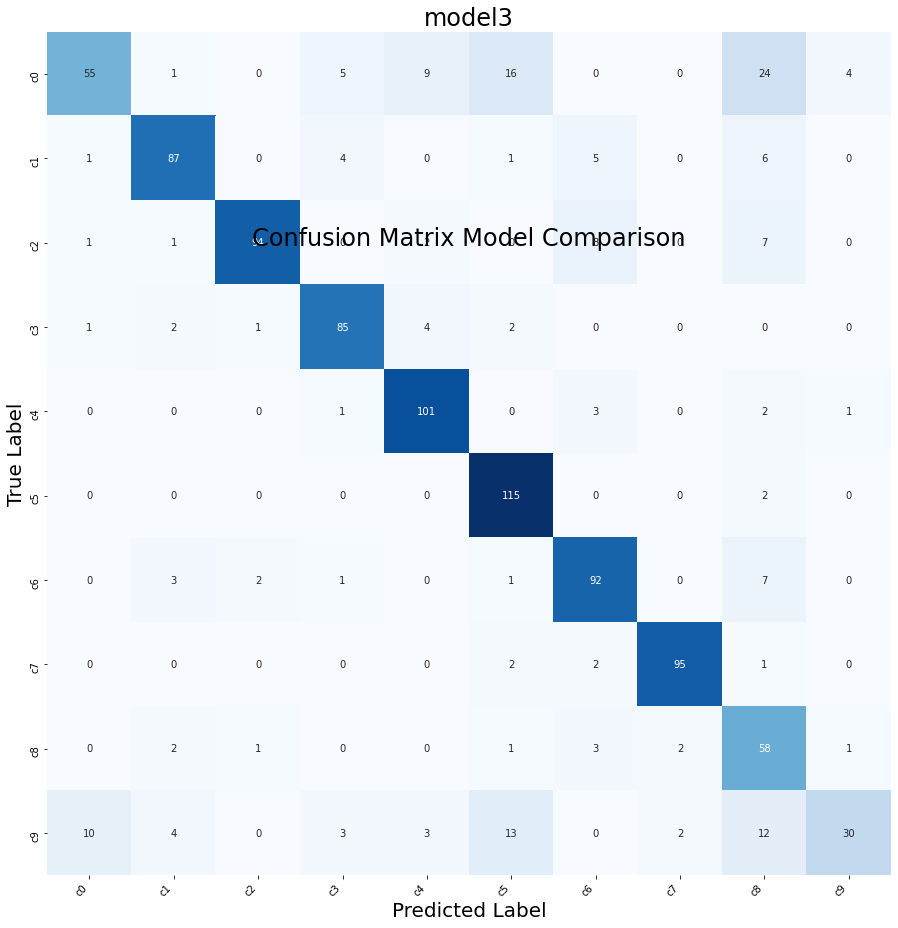

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

fig, axes = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, model_pred_classes, class_names, axes, title=f"model{n_model}")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [18]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   